In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import json
import numpy as np
from shapely.geometry import Point, Polygon
from utils.geo_plot import setup_ax, plot_locs

from typing import Dict, Iterable, List, Optional

import importlib
import preprocessing.create_folds_b
importlib.reload(preprocessing.create_folds_b)

<module 'preprocessing.create_folds_b' from 'c:\\Users\\Benjamin\\Desktop\\Exjobb\\CreateFolds\\preprocessing\\create_folds_b.py'>

# Read data and remove points to break cluster chains

In [2]:
dhs_df_og = pd.read_csv('../dhs_clusters.csv', float_precision='high', index_col=False)

dhs_locs = dhs_df_og[['lat', 'lon']].values

#fold_names = ['A', 'B', 'C', 'D', 'E']
fold_names = ['90-92', '93-95', '96-98', '99-01', '02-04', '05-07', '08-10', '11-13', '14-16', '17-19']


In [3]:
# Read regions to remove from JSON
with open('remove_regions2.json') as f:
    remove_regions_gj = json.load(f)

# Create polygon regions to remove points within
remove_regions = []
for region in remove_regions_gj['features']:
    remove_regions.append(Polygon(region['geometry']['coordinates'][0]))

# Method to determine whether point lies within polygon or not
def in_polys(point, polys):
  for poly in polys:
    if point.within(poly):
      return True
  return False

# Remove points within polygons
dhs_df = dhs_df_og.copy()
dhs_df['geometry'] = dhs_df_og.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
dhs_df = dhs_df[~(dhs_df['geometry'].apply(lambda p: in_polys(p, remove_regions)))]

dhs_df = dhs_df.drop(columns='geometry')
dhs_df.head()

,country,year,lat,lon,GID_1,GID_2,households,rural,iwi
0,angola,2015,-8.589805,13.640789,AGO.1,AGO.1.2,21,0,62.334459
1,angola,2016,-7.718385,14.122619,AGO.1,AGO.1.5,9,1,8.226589
2,angola,2015,-8.592545,13.654425,AGO.1,AGO.1.2,19,0,62.760211
3,angola,2016,-8.652260,13.517859,AGO.11,AGO.11.1,12,1,68.211697
4,angola,2015,-7.852511,13.721998,AGO.1,AGO.1.1,15,1,14.825944


In [4]:
print(len(dhs_df))
print(len(dhs_df_og))

56776
57195


# Plotting and helper methods

In [5]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

In [6]:
def plot_iwi_distribution(dhs_df, folds, plot_title):

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.figure(figsize=(20, 10), dpi=80)
    fig, axes=plt.subplots(1,1, figsize=(20,10))
    for i, fold in enumerate(folds.keys()):
        x = dhs_df['iwi'].loc[folds[fold]].values
        plt.axvline(x=np.mean(x), color=colors[i], alpha=0.4)
        ax=sns.kdeplot(data=x, color=colors[i])
        
        print("fold {} - MEAN: ".format(fold), np.mean(x), ", STD DEV: ", np.std(x))

    fig.legend(labels=folds.keys(), prop={'size': 20})
    ax.yaxis.label.set_size(24)
    ax.xaxis.label.set_size(24)
    plt.xticks(fontsize=22, rotation=90)
    plt.yticks(fontsize=18, rotation=90)
    plt.xlabel('IWI')
    plt.ylabel('Density')
    plt.title(plot_title, fontsize=22)

    plt.show()

In [ ]:
def select_representative_fold(df_train_val, folds, prints=False):
    means = {f: df_train_val['iwi'].loc[folds[f]].mean() for f in folds.keys()}
    mean_tot = df_train_val['iwi'].mean()
    mean_diff = {f: abs(means[f] - mean_tot) for f in folds.keys()}

    stds = {f: df_train_val['iwi'].loc[folds[f]].std() for f in folds.keys()}
    std_tot = df_train_val['iwi'].std()
    std_diff = {f: abs(stds[f] - std_tot) for f in folds.keys()}

    # Weigh having correct mean more important than standard deviation
    tot_diff = {f: mean_diff[f] + std_diff[f]/2 for f in folds.keys()}
    val_fold = min(tot_diff, key=tot_diff.get)

    if prints:
        print("MEANS: ")
        print("Folds: ", means)
        print("Total: ", mean_tot)
        print("Diff: ", mean_diff)
        print()
        print("STDS: ")
        print("Folds: ", stds)
        print("Total: ", std_tot)
        print("Diff: ", std_diff)
        print()
        print("TOTAL DIFF SCORE: ", tot_diff)
        print()
        print("Most representative fold: ", val_fold)


    return val_fold

In [7]:
def divide_safely_by_zero(x, y):
    if y == 0:
        return 0
    else:
        return x / y

## Creating .py-method


In [36]:
dhs_df.head()
grouped = dhs_df.groupby('year')
year_indices_dict = grouped.groups

year_indices_dict[1991]


timespan_indices: Dict[str, List[int]] = {f: [] for f in fold_names}
timespan_indices

timespan_indices[fold_names[0]].extend(year_indices_dict[1991])
timespan_indices[fold_names[0]].extend(year_indices_dict[1992])

timespan = 0
counter = 0
for year in year_indices_dict:
    
    if year == 1991 or year == 1992:
        continue

    if counter % 3 == 0:
        timespan += 1
        print("year: ", year, " timespan: ", timespan)
        if year == 2003:
            counter += 1
        
    
    timespan_indices[fold_names[timespan]].extend(year_indices_dict[year])
    
    counter += 1
    print(year)
    



year:  1993  timespan:  1
1993
1994
1995
year:  1996  timespan:  2
1996
1997
1998
year:  1999  timespan:  3
1999
2000
2001
year:  2003  timespan:  4
2003
2004
year:  2005  timespan:  5
2005
2006
2007
year:  2008  timespan:  6
2008
2009
2010
year:  2011  timespan:  7
2011
2012
2013
year:  2014  timespan:  8
2014
2015
2016
year:  2017  timespan:  9
2017
2018
2019


In [42]:
## Check that counts are correct

print('17-19')
print(len(timespan_indices['17-19']))

print(len(year_indices_dict[2017]))
print(len(year_indices_dict[2018]))
print(len(year_indices_dict[2019]))
print(len(year_indices_dict[2017]) + len(year_indices_dict[2018]) + len(year_indices_dict[2019]))

print()
print('90-92')
print(len(timespan_indices['90-92']))


print(len(year_indices_dict[1991]))
print(len(year_indices_dict[1992]))
print(len(year_indices_dict[1991]) + len(year_indices_dict[1992]))

print()
print('02-04')
print(len(timespan_indices['02-04']))

print(len(year_indices_dict[2003]))
print(len(year_indices_dict[2004]))
print(len(year_indices_dict[2003]) + len(year_indices_dict[2004]))

print()

print('08-10')
print(len(timespan_indices['08-10']))

print(len(year_indices_dict[2008]))
print(len(year_indices_dict[2009]))
print(len(year_indices_dict[2010]))
print(len(year_indices_dict[2008]) + len(year_indices_dict[2009]) + len(year_indices_dict[2010]))



17-19
6299
1280
3857
1162
6299

90-92
924
142
782
924

02-04
4129
2783
1346
4129

08-10
8205
3781
1420
3004
8205


In [46]:
#timespan_indices['02-04']
year_indices_dict[2015]

    

Int64Index([    0,     2,     4,     5,     8,    10,    12,    15,    16,
               19,
            ...
            57185, 57186, 57187, 57188, 57189, 57190, 57191, 57192, 57193,
            57194],
           dtype='int64', length=3780)

FOLD SIZES:
90-92 :  924
93-95 :  2126
96-98 :  1685
99-01 :  4079
02-04 :  4129
05-07 :  5717
08-10 :  8205
11-13 :  10191
14-16 :  13421
17-19 :  6299


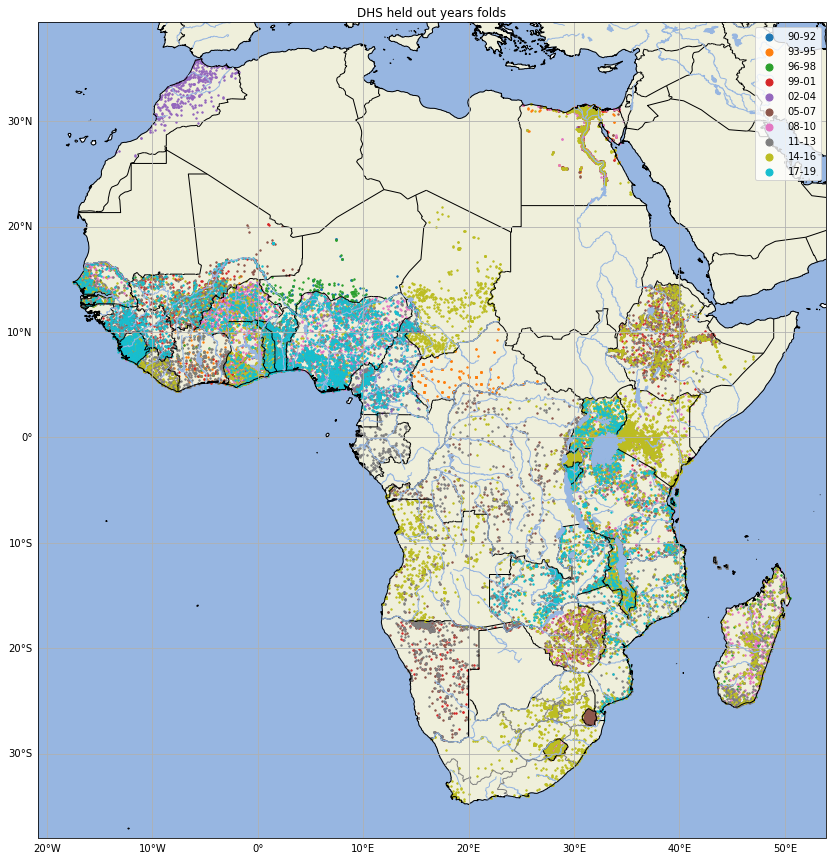

fold 90-92 - MEAN:  38.27471661574783 , STD DEV:  15.240986977726905
fold 93-95 - MEAN:  33.096163076580595 , STD DEV:  17.449869466267852
fold 96-98 - MEAN:  22.250624793833616 , STD DEV:  12.08632557442377
fold 99-01 - MEAN:  29.92489218116623 , STD DEV:  19.282396339233784
fold 02-04 - MEAN:  36.2530257071606 , STD DEV:  20.232844506734477
fold 05-07 - MEAN:  32.605152027385046 , STD DEV:  21.043449900594396
fold 08-10 - MEAN:  30.83168324889628 , STD DEV:  19.747817698280034
fold 11-13 - MEAN:  29.181558282675127 , STD DEV:  17.412534702315696
fold 14-16 - MEAN:  34.39014940861011 , STD DEV:  21.28924902656891
fold 17-19 - MEAN:  33.19336548155672 , STD DEV:  16.416246834274794


<Figure size 1600x800 with 0 Axes>

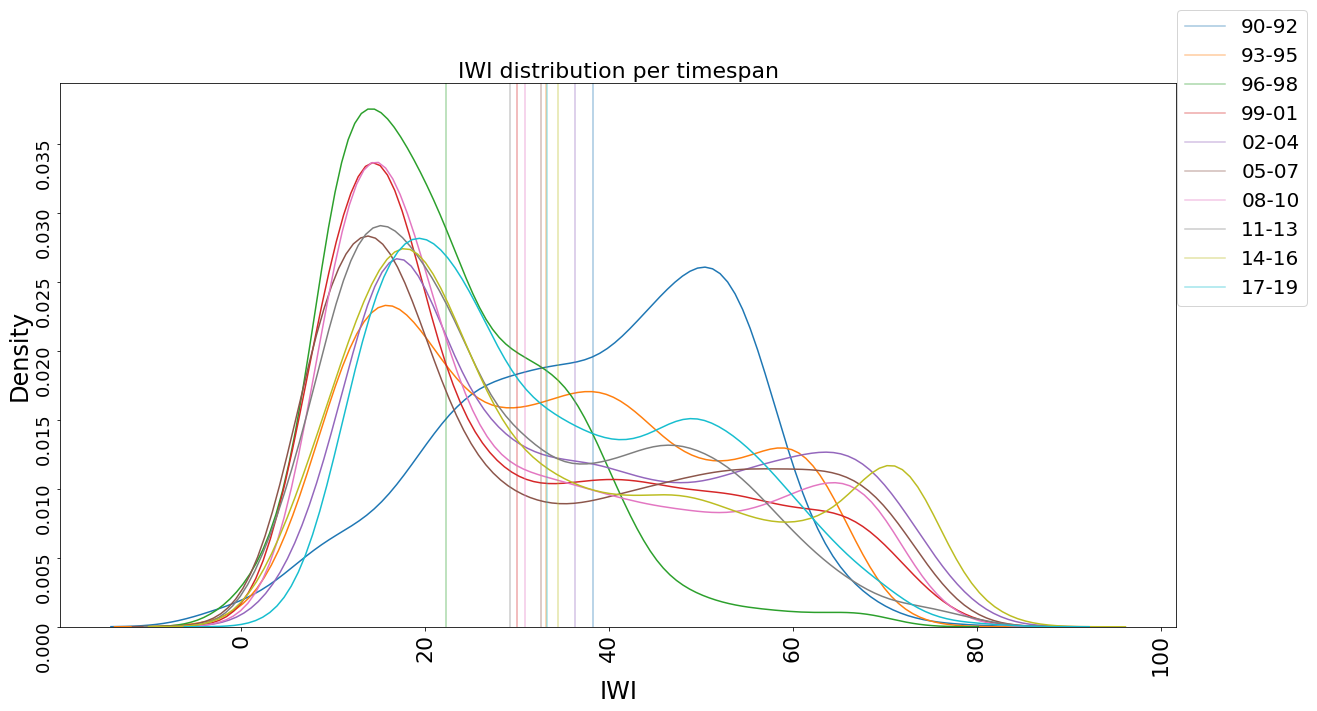

In [52]:
print("FOLD SIZES:")
for timespan in timespan_indices:
    print(timespan, ": ", len(timespan_indices[timespan]))

plot_splits({f: dhs_locs[timespan_indices[f]] for f in fold_names},
            title='DHS held out years folds')
            
plot_iwi_distribution(dhs_df, timespan_indices, plot_title='IWI distribution per timespan')


## Create train and validation sets for each test fold

FOLD:  90-92
num clusters: 4412
num outliers: 7863
max cluster size (excl. outliers): 1963


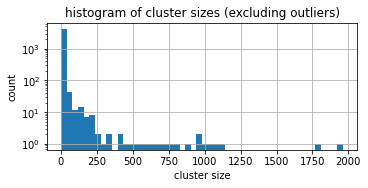

fold 1 - MEAN:  31.873928387049403 , STD DEV:  19.82308837420389
fold 2 - MEAN:  31.909521296123216 , STD DEV:  19.04118803523428
fold 3 - MEAN:  32.35882117828732 , STD DEV:  20.13242090237647
fold 4 - MEAN:  31.839585279527945 , STD DEV:  18.782222761973987


<Figure size 1600x800 with 0 Axes>

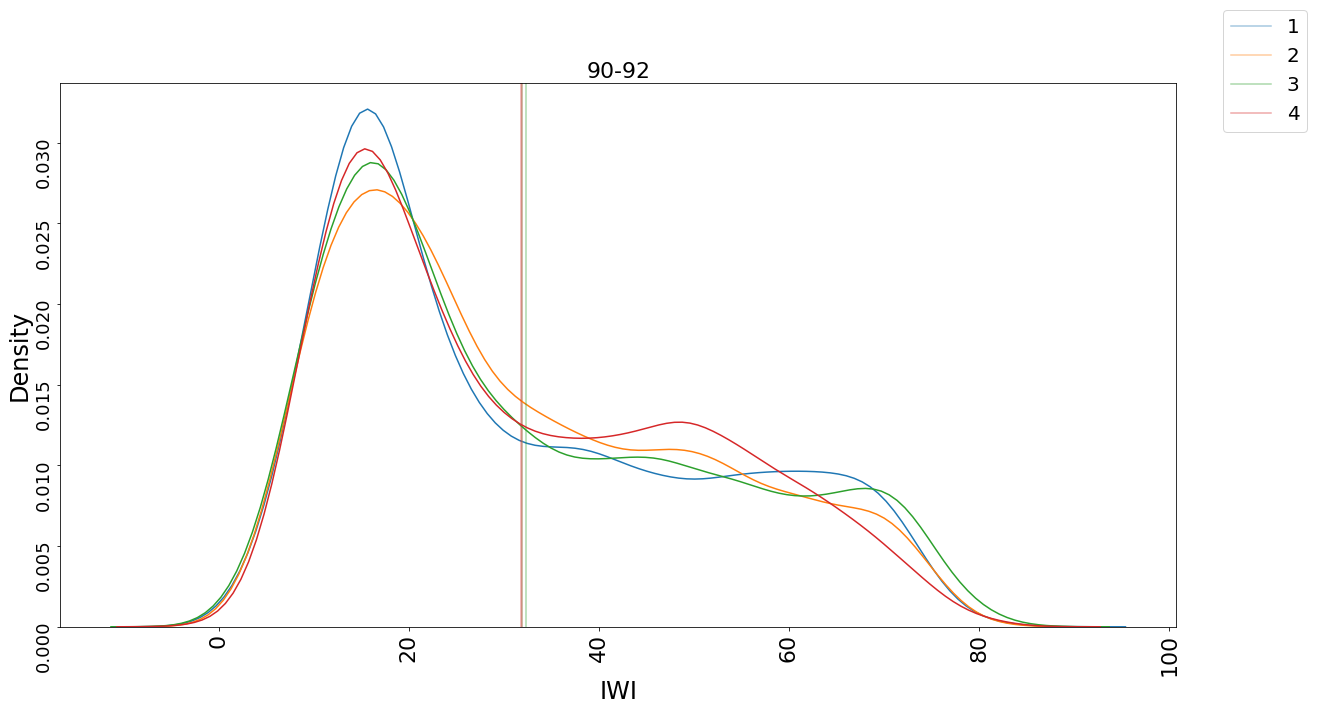

VAL FOLD:  2
_____________________
FOLD:  93-95
num clusters: 4339
num outliers: 7831
max cluster size (excl. outliers): 1963


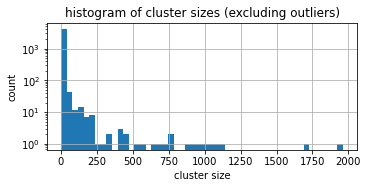

fold 1 - MEAN:  32.19195759969285 , STD DEV:  20.29768106387266
fold 2 - MEAN:  31.73347394105408 , STD DEV:  18.27820296304626
fold 3 - MEAN:  32.609640053494225 , STD DEV:  20.406556445269526
fold 4 - MEAN:  31.70014897227346 , STD DEV:  18.83604334159501


<Figure size 1600x800 with 0 Axes>

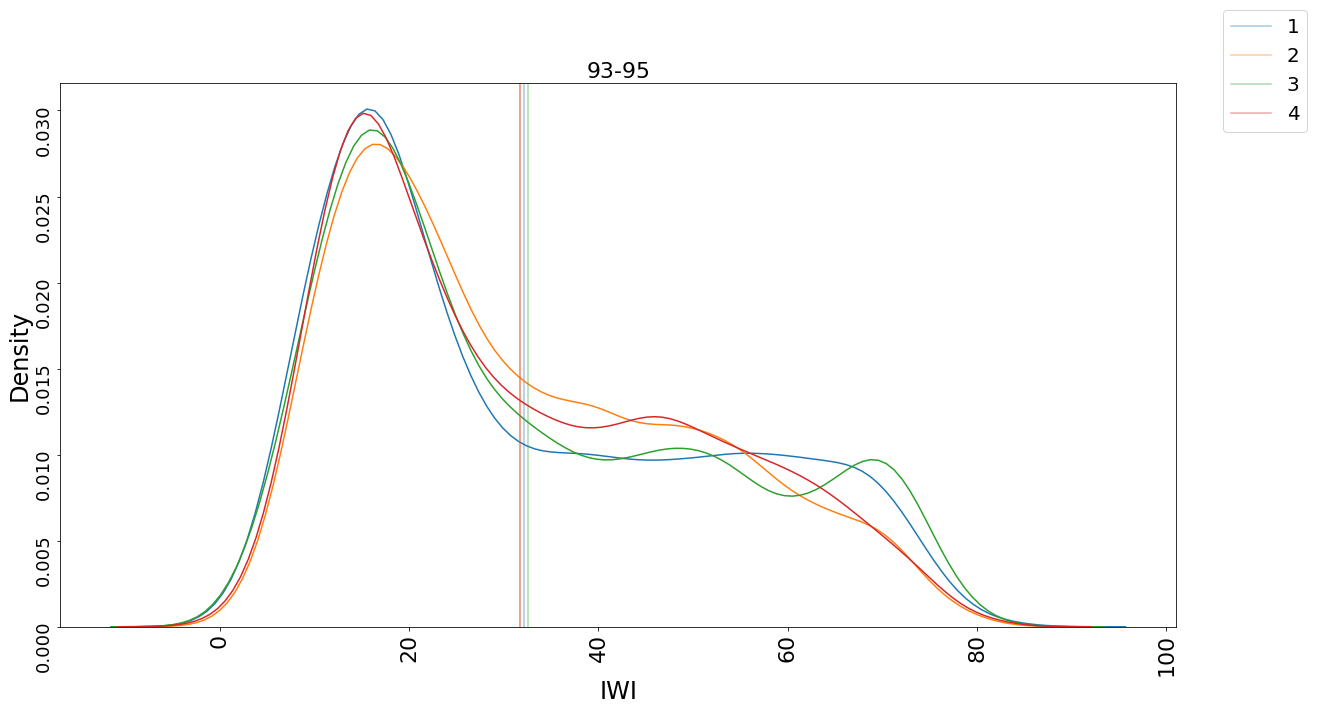

VAL FOLD:  1
_____________________
FOLD:  96-98
num clusters: 4339
num outliers: 7852
max cluster size (excl. outliers): 1963


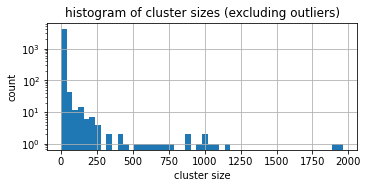

fold 1 - MEAN:  32.551074110217286 , STD DEV:  20.077613012726804
fold 2 - MEAN:  32.751171901042234 , STD DEV:  20.3816126919929
fold 3 - MEAN:  32.15092817082855 , STD DEV:  18.59925675703004
fold 4 - MEAN:  32.14208396176468 , STD DEV:  18.922283981216893


<Figure size 1600x800 with 0 Axes>

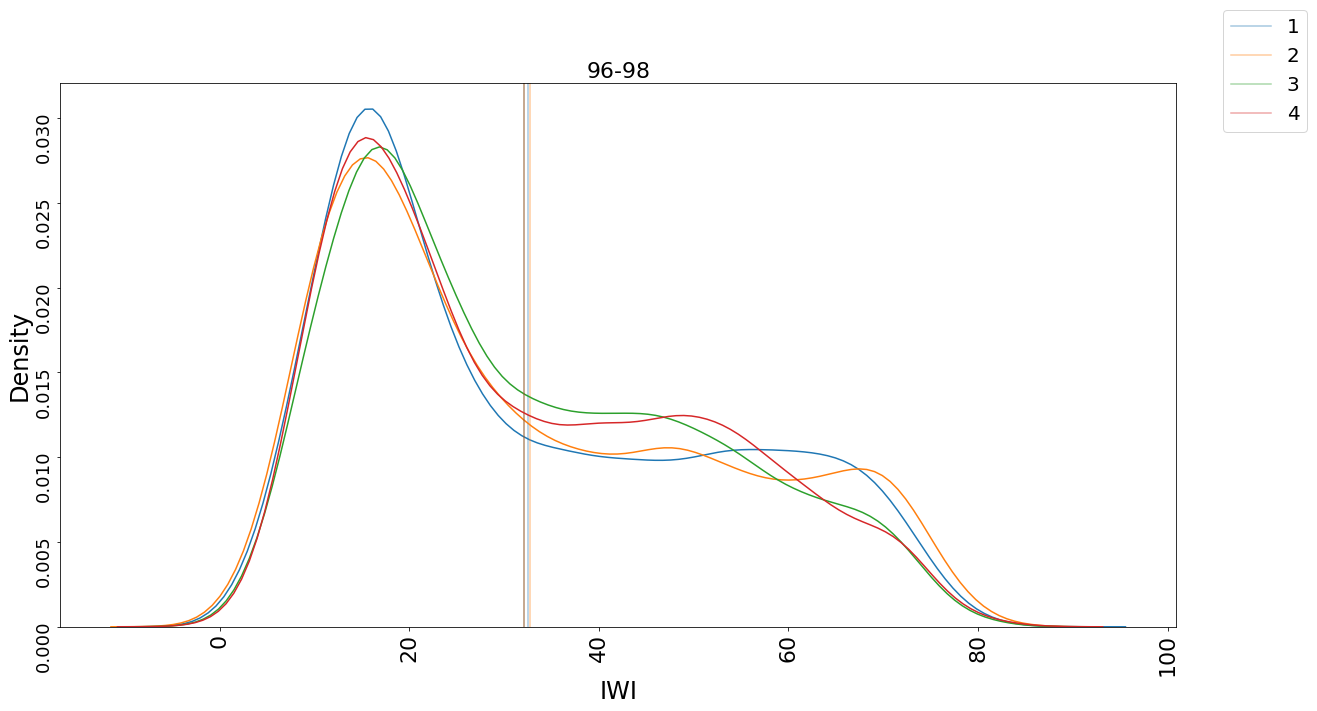

VAL FOLD:  1
_____________________
FOLD:  99-01
num clusters: 4233
num outliers: 7810
max cluster size (excl. outliers): 1869


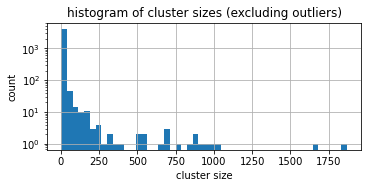

fold 1 - MEAN:  32.66046575709138 , STD DEV:  20.328173094772332
fold 2 - MEAN:  32.55055330359893 , STD DEV:  20.47703479992192
fold 3 - MEAN:  31.90267202754891 , STD DEV:  18.459528462712438
fold 4 - MEAN:  31.94964008529298 , STD DEV:  18.24744518833325


<Figure size 1600x800 with 0 Axes>

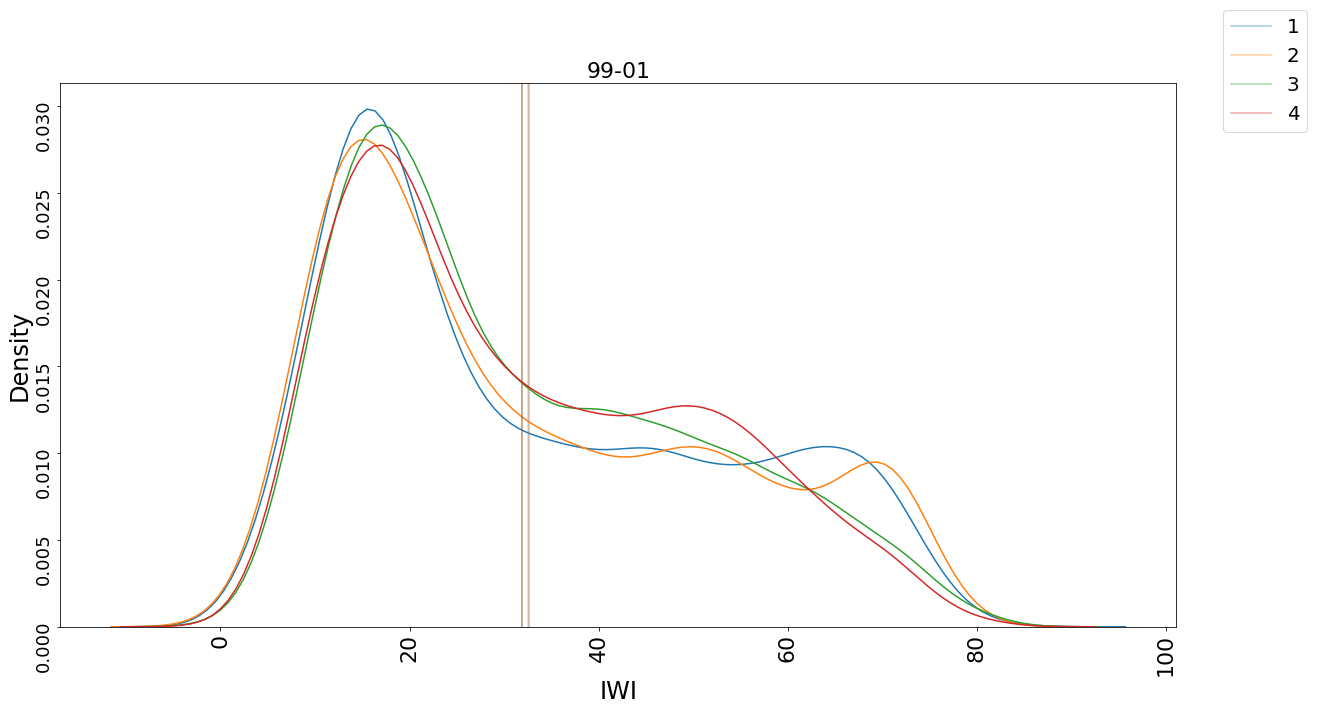

VAL FOLD:  2
_____________________
FOLD:  02-04
num clusters: 4319
num outliers: 7641
max cluster size (excl. outliers): 1963


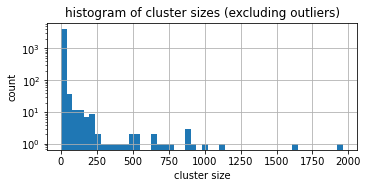

fold 1 - MEAN:  31.759386166332646 , STD DEV:  20.028391741786137
fold 2 - MEAN:  32.40916022614157 , STD DEV:  19.622685188014778
fold 3 - MEAN:  31.474239250471737 , STD DEV:  19.024301824719824
fold 4 - MEAN:  31.44418503296596 , STD DEV:  18.49287886485915


<Figure size 1600x800 with 0 Axes>

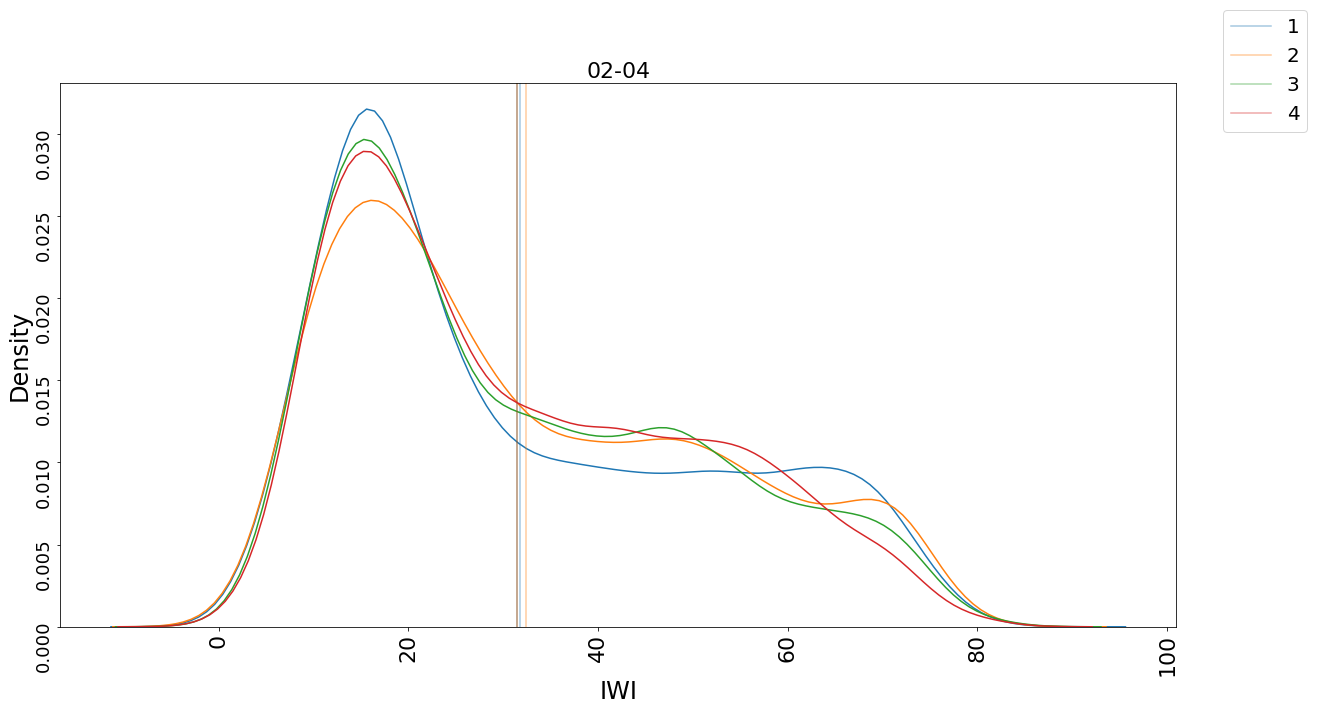

VAL FOLD:  1
_____________________
FOLD:  05-07
num clusters: 4042
num outliers: 7604
max cluster size (excl. outliers): 1663


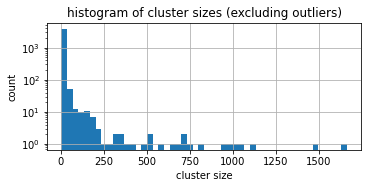

fold 1 - MEAN:  33.309865145480785 , STD DEV:  20.010405066952362
fold 2 - MEAN:  31.6417329197793 , STD DEV:  19.886158021822958
fold 3 - MEAN:  31.566657048913044 , STD DEV:  18.79723498215696
fold 4 - MEAN:  31.645058457748355 , STD DEV:  18.046687549249803


<Figure size 1600x800 with 0 Axes>

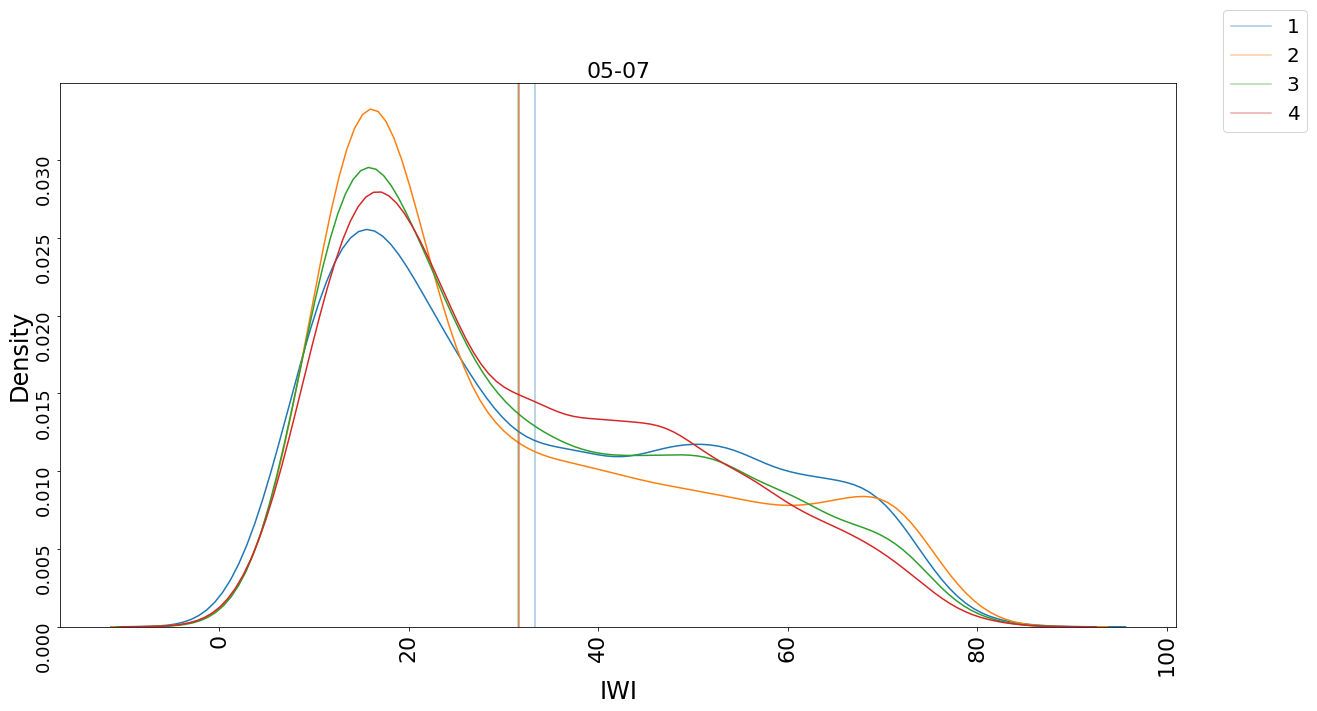

VAL FOLD:  3
_____________________
FOLD:  08-10
num clusters: 4162
num outliers: 7779
max cluster size (excl. outliers): 1600


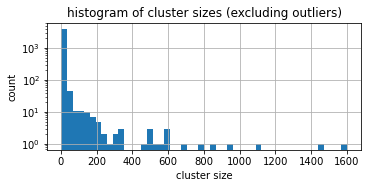

fold 1 - MEAN:  32.61342731199007 , STD DEV:  19.46613296236498
fold 2 - MEAN:  32.58290336084128 , STD DEV:  20.451639211167027
fold 3 - MEAN:  32.0200272985841 , STD DEV:  18.77777127617715
fold 4 - MEAN:  32.029602202438674 , STD DEV:  18.612284160389752


<Figure size 1600x800 with 0 Axes>

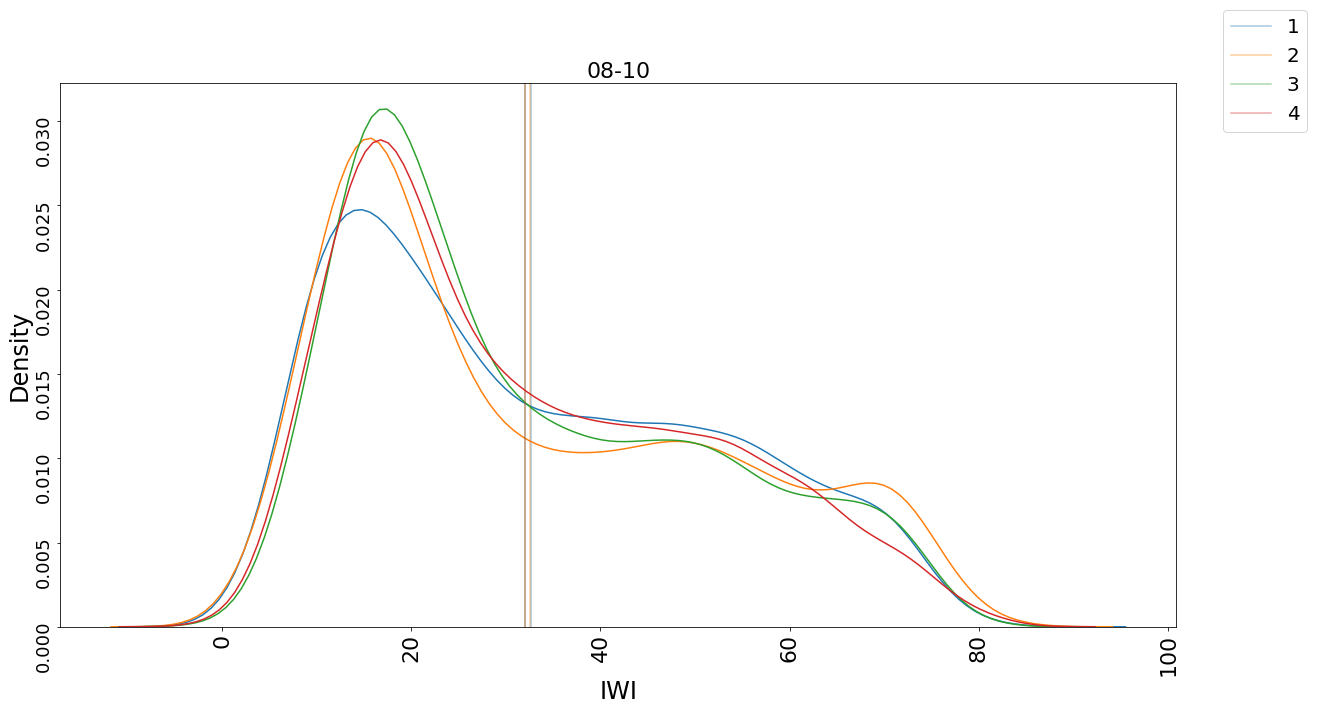

VAL FOLD:  1
_____________________
FOLD:  11-13
num clusters: 3618
num outliers: 7136
max cluster size (excl. outliers): 1920


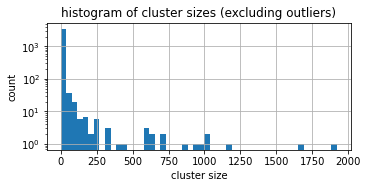

fold 1 - MEAN:  33.57220215986504 , STD DEV:  20.273149917406368
fold 2 - MEAN:  32.45984134257397 , STD DEV:  20.310532609228687
fold 3 - MEAN:  32.440945944773574 , STD DEV:  19.306609984642574
fold 4 - MEAN:  32.46944192298833 , STD DEV:  19.100927529314628


<Figure size 1600x800 with 0 Axes>

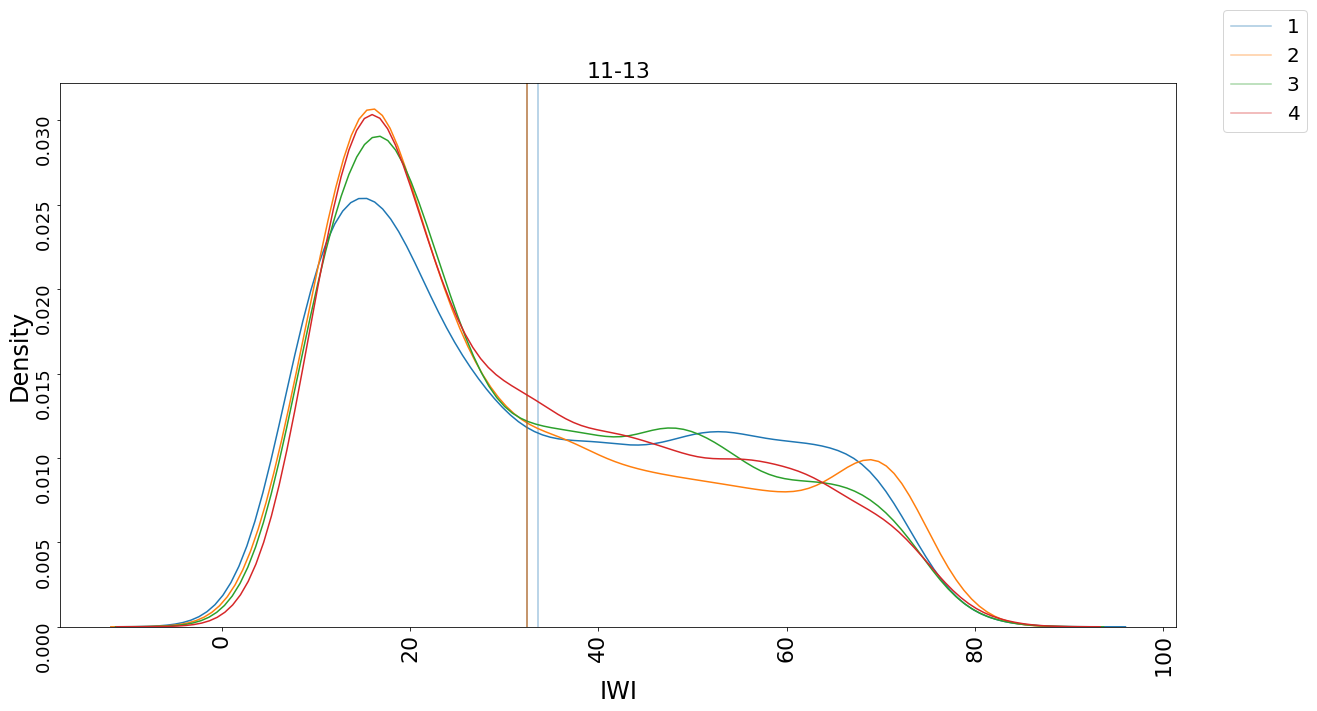

VAL FOLD:  3
_____________________
FOLD:  14-16
num clusters: 3768
num outliers: 6768
max cluster size (excl. outliers): 1487


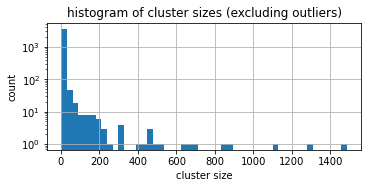

fold 1 - MEAN:  31.90278738444375 , STD DEV:  18.734888089997792
fold 2 - MEAN:  31.167768078960766 , STD DEV:  19.37483108134964
fold 3 - MEAN:  31.238123413633648 , STD DEV:  17.9059879114807
fold 4 - MEAN:  31.24319395213619 , STD DEV:  18.871586060818792


<Figure size 1600x800 with 0 Axes>

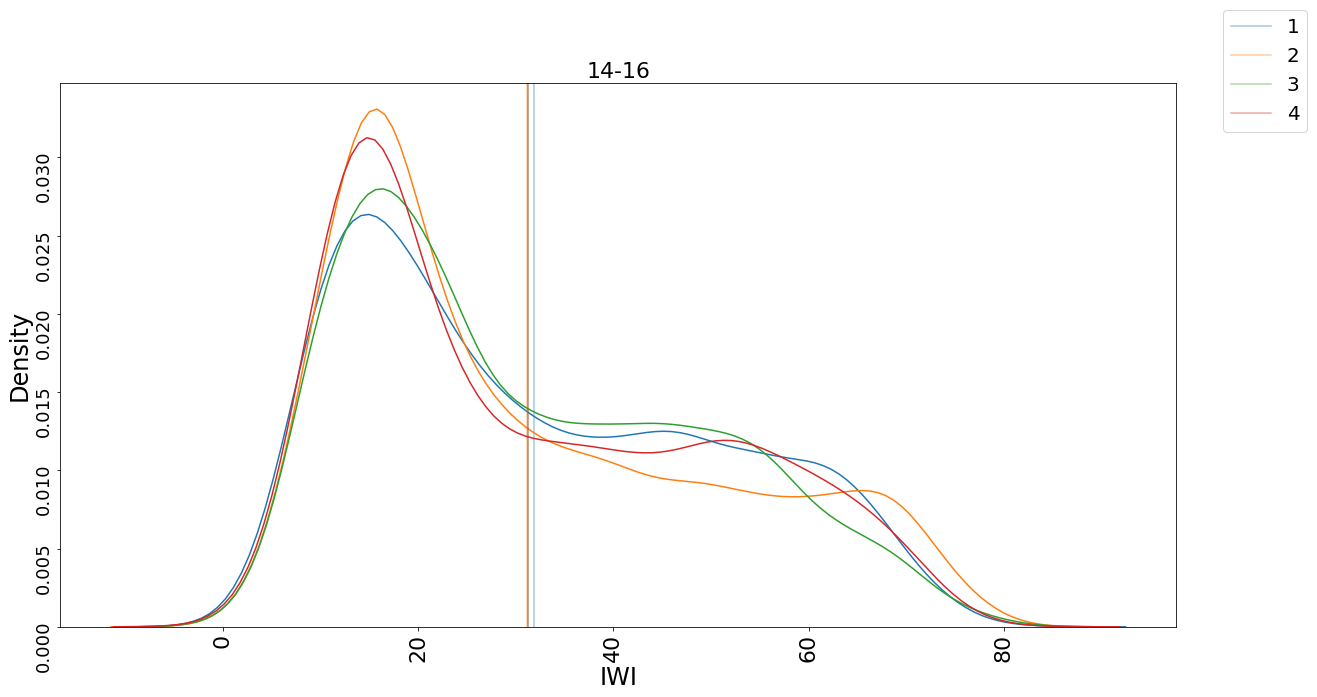

VAL FOLD:  4
_____________________
FOLD:  17-19
num clusters: 4046
num outliers: 7807
max cluster size (excl. outliers): 1920


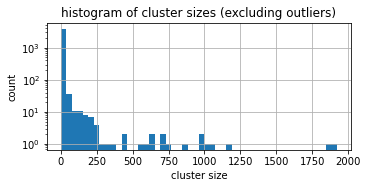

fold 1 - MEAN:  32.183063780769 , STD DEV:  20.463577931934363
fold 2 - MEAN:  32.383958209944595 , STD DEV:  20.398707439488696
fold 3 - MEAN:  31.627471056522857 , STD DEV:  18.660818411154146
fold 4 - MEAN:  31.649182446210204 , STD DEV:  19.39342765669568


<Figure size 1600x800 with 0 Axes>

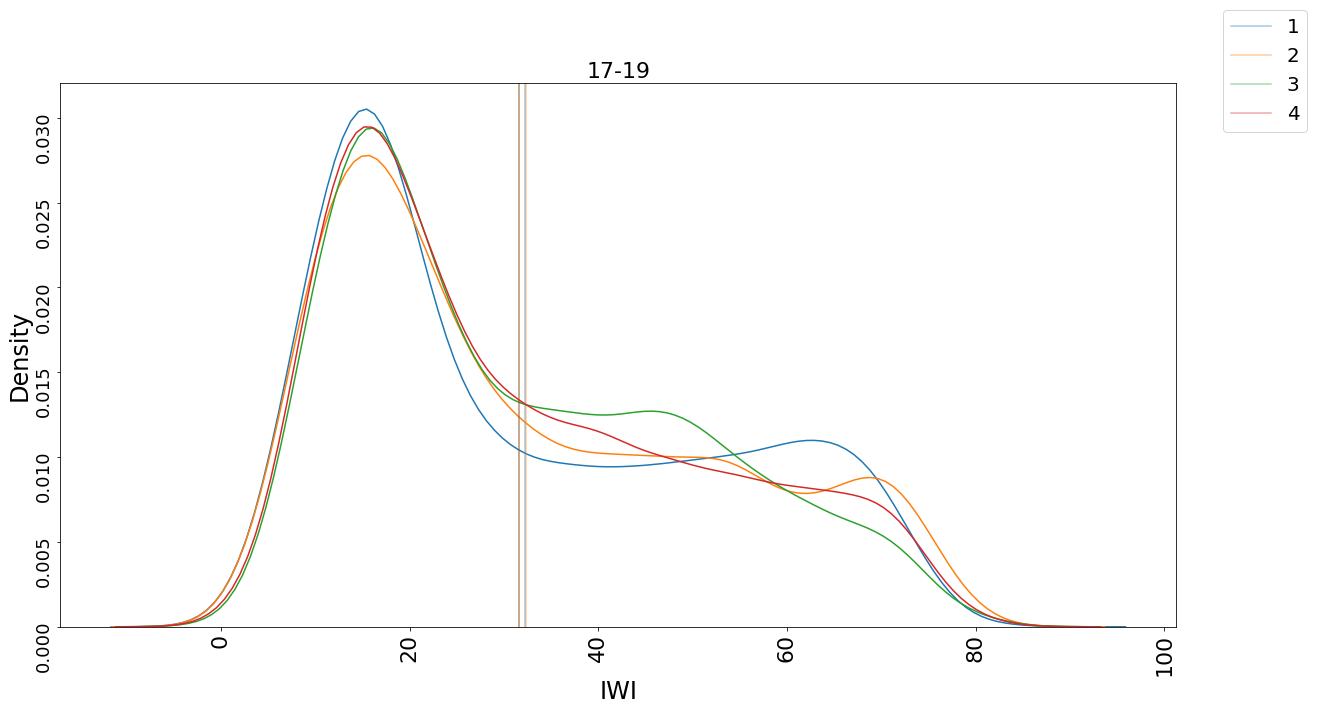

VAL FOLD:  4
_____________________
90-92 :  train :  41888
90-92 :  val :  13964
90-92 :  test :  924

93-95 :  train :  40987
93-95 :  val :  13663
93-95 :  test :  2126

96-98 :  train :  41318
96-98 :  val :  13773
96-98 :  test :  1685

99-01 :  train :  39522
99-01 :  val :  13175
99-01 :  test :  4079

02-04 :  train :  39485
02-04 :  val :  13162
02-04 :  test :  4129

05-07 :  train :  38294
05-07 :  val :  12765
05-07 :  test :  5717

08-10 :  train :  36429
08-10 :  val :  12142
08-10 :  test :  8205

11-13 :  train :  34938
11-13 :  val :  11647
11-13 :  test :  10191

14-16 :  train :  32516
14-16 :  val :  10839
14-16 :  test :  13421

17-19 :  train :  37857
17-19 :  val :  12620
17-19 :  test :  6299



In [49]:
# country_folds: TEST FOLDS
# dhs_df

importlib.reload(preprocessing.create_folds_b)

# DOES NOT WORK WITH FRACTIONS
split_folds = {}
for test_fold in timespan_indices.keys():
    print("FOLD: ", test_fold)

    split_folds[test_fold] = {}

    # Create new DataFrame with just train and val data
    train_val_indices = np.setdiff1d(dhs_df.index.values, timespan_indices[test_fold])
    df_train_val = dhs_df.loc[train_val_indices]

    # Create four folds from train and val data
    #train_val_fold_names = list(timespan_indices.keys())
    #train_val_fold_names.remove(test_fold)
    train_val_fold_names = ['1', '2', '3', '4']
    train_val_folds = preprocessing.create_folds_b.create_folds(df=df_train_val, fold_names=train_val_fold_names, random_state=1338, big_fold_penalty=150)

    plot_iwi_distribution(df_train_val, train_val_folds, test_fold)

    val_fold = select_representative_fold(df_train_val, train_val_folds)
    print("VAL FOLD: ", val_fold)
    #train_folds = train_val_fold_names.remove(val_fold)

    # Assign test data
    split_folds[test_fold]['test'] = timespan_indices[test_fold]

    # Assign validation data
    split_folds[test_fold]['val'] = train_val_folds[val_fold]
    
    # Assign training data
    train_indices = np.setdiff1d(train_val_indices, train_val_folds[val_fold])
    split_folds[test_fold]['train'] = train_indices

    print("_____________________")

for fold in fold_names:
    for dataset in ['train', 'val', 'test']:
        print(fold, ": ", dataset, ": ", len(split_folds[fold][dataset]))
    print()



FOLD SIZES:
90-92 :  924
93-95 :  2126
96-98 :  1685
99-01 :  4079
02-04 :  4129
05-07 :  5717
08-10 :  8205
11-13 :  10191
14-16 :  13421
17-19 :  6299


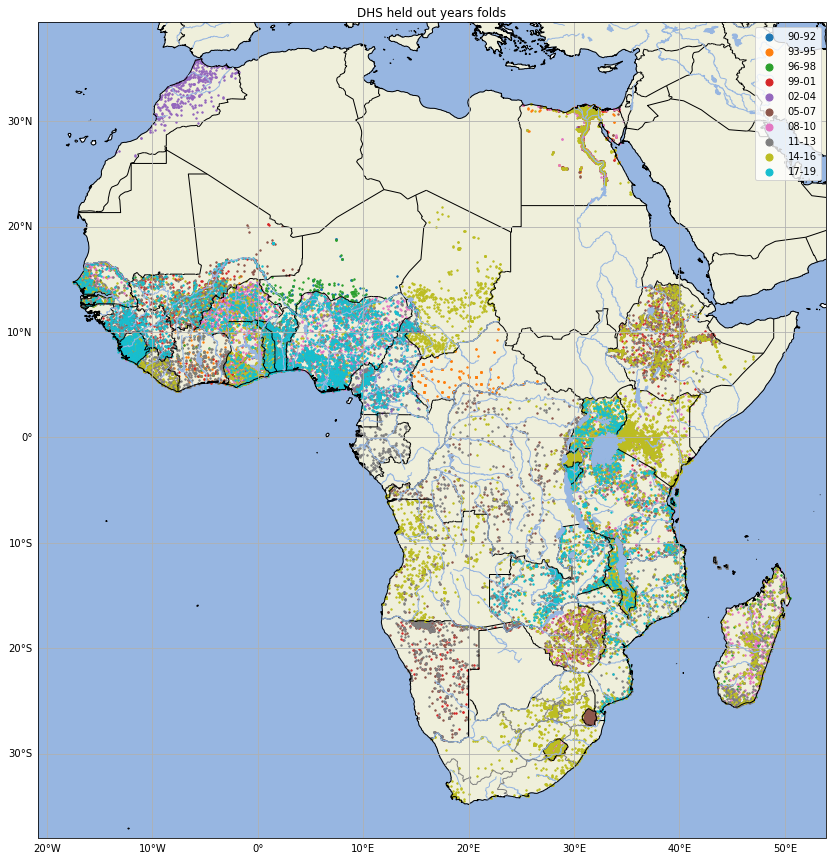

fold 90-92 - MEAN:  38.27471661574783 , STD DEV:  15.240986977726905
fold 93-95 - MEAN:  33.096163076580595 , STD DEV:  17.449869466267852
fold 96-98 - MEAN:  22.250624793833616 , STD DEV:  12.08632557442377
fold 99-01 - MEAN:  29.92489218116623 , STD DEV:  19.282396339233784
fold 02-04 - MEAN:  36.2530257071606 , STD DEV:  20.232844506734477
fold 05-07 - MEAN:  32.605152027385046 , STD DEV:  21.043449900594396
fold 08-10 - MEAN:  30.83168324889628 , STD DEV:  19.747817698280034
fold 11-13 - MEAN:  29.181558282675127 , STD DEV:  17.412534702315696
fold 14-16 - MEAN:  34.39014940861011 , STD DEV:  21.28924902656891
fold 17-19 - MEAN:  33.19336548155672 , STD DEV:  16.416246834274794


<Figure size 1600x800 with 0 Axes>

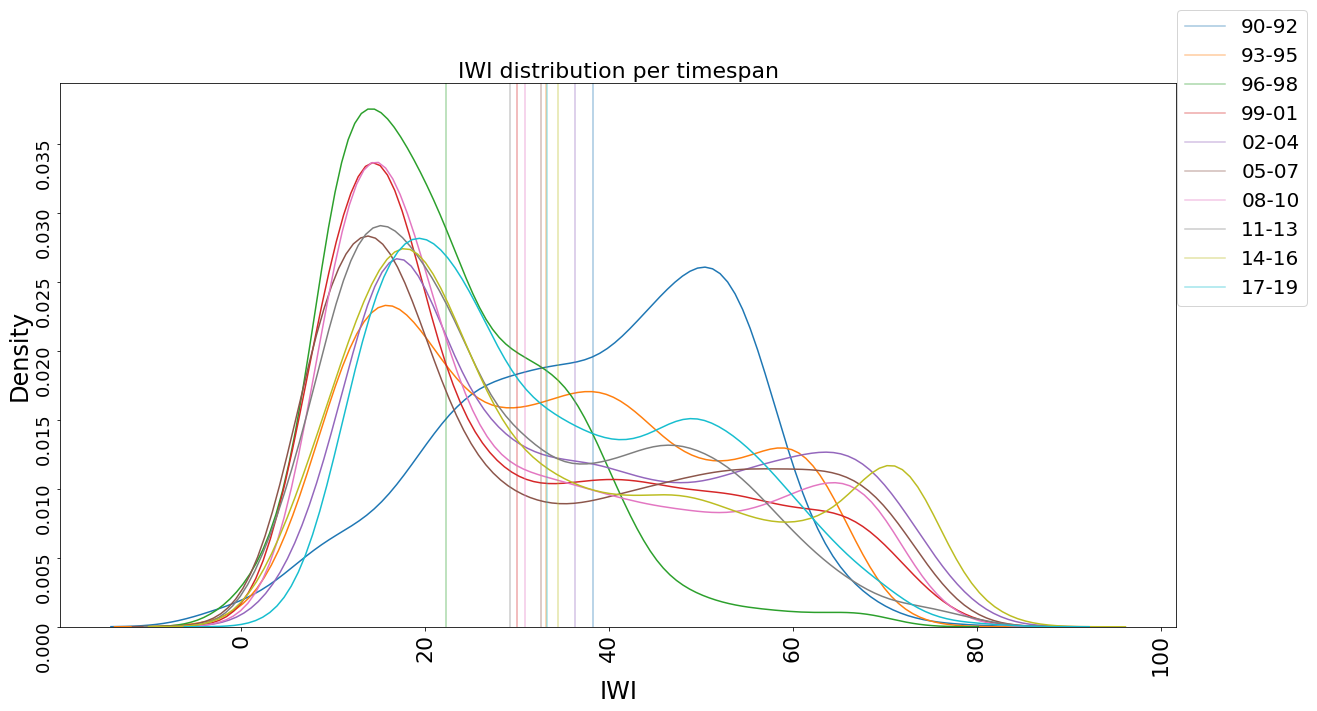

# Save folds to pkl-file

In [53]:
# SAVE FOLDS
preprocessing.create_folds_b.save_folds(
   folds_path='held_out_years_folds.pkl',
   folds=split_folds,
   check_exists=False)

In [58]:
with open('held_out_years_folds.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())

print(data['17-19'].keys())

print(len(data['17-19']['test']))

dict_keys(['90-92', '93-95', '96-98', '99-01', '02-04', '05-07', '08-10', '11-13', '14-16', '17-19'])
dict_keys(['test', 'val', 'train'])
6299
